In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoModel , AutoImageProcessor , AutoTokenizer 
from datasets import load_dataset , Dataset , concatenate_datasets
from PIL import Image
from datasets import Image as dImage
import torch
from torch import nn

torch.cuda.empty_cache()

2024-05-19 01:02:02.356573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 01:02:02.852450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def training_img_address(input):
    IMAGE_DIR = "./train2014_3d"
    input["image_id"] = f"{IMAGE_DIR}/{input['image_id']}"
    return input

In [3]:
SAMPLE_SET = "10k"

df = pd.read_pickle(f"vqa_v2_sampled_{SAMPLE_SET}_clipped.pkl")
SAMPLES = len(df)

print("Number of samples are : " , SAMPLES)

df.head()

Number of samples are :  14300


,question,question_type,question_id,image_id,answer_type,label
0,Are all of the people currently skiing?,are,355111000,COCO_train2014_000000355111.jpg,yes/no,"{'ids': ['yes', 'no'], 'weights': [0.1, 0.9]}"
1,Are both his skis in contact with the snow?,are,492261002,COCO_train2014_000000492261.jpg,yes/no,"{'ids': ['yes'], 'weights': [1.0]}"
2,Are you allowed to cross the street now?,are,364064002,COCO_train2014_000000364064.jpg,yes/no,"{'ids': ['yes', 'no'], 'weights': [0.43, 0.57]}"
3,Are both stoves gas stoves?,are,110381001,COCO_train2014_000000110381.jpg,yes/no,"{'ids': ['yes', 'no'], 'weights': [0.8, 0.2]}"
4,Are all the cars white?,are,481257003,COCO_train2014_000000481257.jpg,yes/no,"{'ids': ['no', 'yes'], 'weights': [0.95, 0.05]}"


In [4]:
# X_img = np.array([np.array(Image.open(i)) for i in dataset["image_id"]])
# X_text = np.array(dataset["question"])
# X_img.shape , X_text.shape

Creating Labels

In [5]:
import itertools

labels = [item['ids'] for item in df['label']]
flattened_labels = list(itertools.chain(*labels))
unique_labels = list(set(flattened_labels))

label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()} 

In [6]:
label2id

{'fair': 0,
 'pan': 1,
 'in background': 2,
 'motorbike': 3,
 'a': 4,
 'peach': 5,
 'corner': 6,
 'police': 7,
 'africa': 8,
 'behind': 9,
 '24': 10,
 'straight': 11,
 'house': 12,
 'animal': 13,
 'skateboarding': 14,
 'flowers': 15,
 'sink': 16,
 'school': 17,
 'right one': 18,
 'wii remote': 19,
 'pitcher': 20,
 'beef': 21,
 'khaki': 22,
 'center': 23,
 'round': 24,
 'gray and white': 25,
 'playing video game': 26,
 'teal': 27,
 'brushing teeth': 28,
 'traveling': 29,
 'oven': 30,
 '13': 31,
 'ocean': 32,
 'cows': 33,
 'sunglasses': 34,
 'game controller': 35,
 'burger': 36,
 'lettuce': 37,
 'baseball cap': 38,
 'waiting': 39,
 'soda': 40,
 'hay': 41,
 'skating': 42,
 'dark blue': 43,
 'parked': 44,
 'vanilla': 45,
 'country': 46,
 'fire hydrant': 47,
 'fence': 48,
 'backpack': 49,
 'women': 50,
 'black and brown': 51,
 'wood': 52,
 'racing': 53,
 '17': 54,
 'hp': 55,
 'middle': 56,
 'chicken': 57,
 'red and green': 58,
 'towel': 59,
 'day': 60,
 'football': 61,
 'vegetable': 62,
 't

In [7]:
NUM_CLASSES = len(id2label)
print("Number of Classes : " , NUM_CLASSES)

Number of Classes :  898


In [8]:
def labelise(x):
    h = [0 for i in range(NUM_CLASSES)]
    for t , w in zip(x['ids'] , x['weights']):
        h[label2id[t]] = w
    return h

df["label"] = df["label"].apply(labelise)

df.head()

,question,question_type,question_id,image_id,answer_type,label
0,Are all of the people currently skiing?,are,355111000,COCO_train2014_000000355111.jpg,yes/no,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Are both his skis in contact with the snow?,are,492261002,COCO_train2014_000000492261.jpg,yes/no,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Are you allowed to cross the street now?,are,364064002,COCO_train2014_000000364064.jpg,yes/no,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Are both stoves gas stoves?,are,110381001,COCO_train2014_000000110381.jpg,yes/no,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Are all the cars white?,are,481257003,COCO_train2014_000000481257.jpg,yes/no,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
dataset = Dataset.from_pandas(df)
dataset = dataset.map(training_img_address)
dataset = dataset.cast_column("image_id", dImage())

dataset

Map: 100%|██████████| 14300/14300 [00:00<00:00, 18048.03 examples/s]


Dataset({
    features: ['question', 'question_type', 'question_id', 'image_id', 'answer_type', 'label'],
    num_rows: 14300
})

In [10]:
# def resize_image(x):
#     x["image_id"] = x["image_id"].resize((640 , 480))
#     return x

# dataset = dataset.map(resize_image)
# dataset.save_to_disk(f"./vqa_v2_sampled_{SAMPLE_SET}_clipped.hf")

dataset = Dataset.load_from_disk(f"./vqa_v2_sampled_{SAMPLE_SET}_clipped.hf")
dataset

Dataset({
    features: ['question', 'question_type', 'question_id', 'image_id', 'answer_type', 'label'],
    num_rows: 14300
})

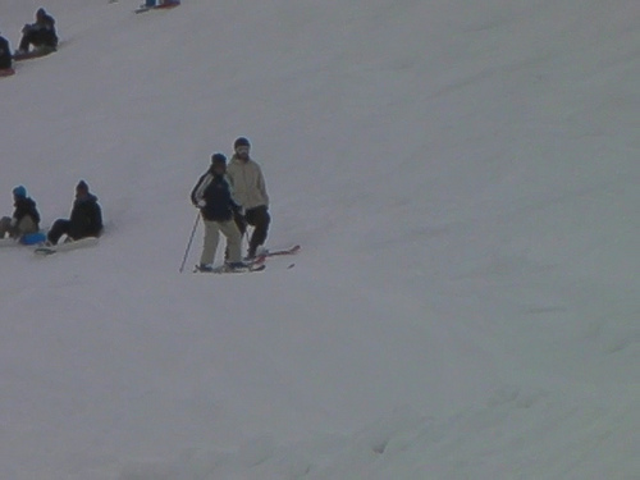

In [11]:
dataset[0]["image_id"]

In [12]:
# dataset_label = Dataset.from_pandas(df["label"])
# dataset_label

df_label = df["label"].to_frame(name='label')
dataset_label = Dataset.from_pandas(df_label)

dataset = dataset.remove_columns(["label"])
dataset = concatenate_datasets([dataset , dataset_label] , axis=1)

In [13]:
a1 , a2 = torch.argmax(torch.Tensor(dataset[0]["label"])) , torch.argmax(torch.Tensor(dataset[8000]["label"]))
a11 , a22 = np.argmax(df["label"][0]) , np.argmax(df["label"][8000])
q1 , q2 = dataset[0]["question"] , dataset[8000]["question"]
q1 , q2 , id2label[a1.item()] , id2label[a2.item()] , id2label[a11] , id2label[a22]

# id2label[np.argmax(dataset[0]["label"])]

('Are all of the people currently skiing?',
 'What are the people playing?',
 'no',
 'skateboarding',
 'no',
 'skateboarding')

In [14]:
dataset = dataset.shuffle(seed=42)

Testing BERT and ViT

In [15]:
DEVICE = "cuda"

vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit_model = AutoModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)

/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import BertTokenizer , BertModel

bert_processor = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(DEVICE)

/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
from peft import LoraConfig, TaskType
from peft import get_peft_model

peft_config = LoraConfig(r=8, lora_alpha=32, lora_dropout=0.1,
                        target_modules = [
                            "query" , "key" , "value" , "dense"
                        ])
# help(TaskType)
vit_model_lora = get_peft_model(vit_model, peft_config)
vit_model_lora.print_trainable_parameters()

trainable params: 1,339,392 || all params: 87,728,640 || trainable%: 1.5267


In [18]:
peft_config = LoraConfig(r=8, lora_alpha=32, lora_dropout=0.1,
                        target_modules = [
                            "query" , "key" , "value" , "dense"
                        ])

bert_model_lora = get_peft_model(bert_model, peft_config)
bert_model_lora.print_trainable_parameters()

trainable params: 1,339,392 || all params: 110,821,632 || trainable%: 1.2086


In [19]:
class CustomVITModel(nn.Module):
    def __init__(self):
        super(CustomVITModel, self).__init__()
        self.vit = vit_model_lora
        self.bert = bert_model_lora
        ### New layers:
        self.linear1 = nn.Linear(768 * 2, 256)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.dpout1 = nn.Dropout(0.25)
        self.dpout2 = nn.Dropout(0.25)
        self.linear2 = nn.Linear(256, 64) ## 3 is the number of classes in this example
        self.linear3 = nn.Linear(64, NUM_CLASSES) ## 3 is the number of classes in this example
        self.sigmoid = nn.Softmax()

    def forward(self, pixel_values , input_ids , attention_mask):
        vit_outp = self.vit(pixel_values)
        vit_last_hidden_state, vit_pooled_output = vit_outp.last_hidden_state , vit_outp.pooler_output
        
        bert_outp = self.bert(input_ids , attention_mask=attention_mask)
        bert_last_hidden_state, bert_pooled_output = bert_outp.last_hidden_state , bert_outp.pooler_output
        
        # last_hidden_state = last_hidden_state.cuda()
        # pooled_output = pooled_output.cuda()

        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        
        combined_input = torch.cat([vit_pooled_output,bert_pooled_output] , axis=1)
        
        # linear1_output = self.linear1(last_hidden_state[:,0,:].view(-1,768)) ## extract the 1st token's embeddings
        out = self.linear1(combined_input)
        out = self.relu1(out)
        # out = nn.functional.batch_norm(out)
        out = self.dpout1(out)

        out = self.linear2(out)
        out = self.relu2(out)
        # out = nn.functional.batch_norm(out)
        out = self.dpout1(out)
        
        out = self.linear3(out)
        
        pred = out
        # pred = self.sigmoid(linear2_output)

        return pred

# tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-xxl-cased") 
model_custom = CustomVITModel() # You can pass the parameters if required to have more flexible model
model_custom.to(DEVICE) ## can be gpu
criterion = nn.CrossEntropyLoss() ## If required define your own criterion
# criterion = nn.BCELoss() ## If required define your own criterion
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_custom.parameters()) , lr=3e-5)

In [20]:
from torchinfo import summary

summary(model_custom)

Layer (type:depth-idx)                                                      Param #
CustomVITModel                                                              --
├─PeftModel: 1-1                                                            --
│    └─LoraModel: 2-1                                                       --
│    │    └─ViTModel: 3-1                                                   87,728,640
├─PeftModel: 1-2                                                            --
│    └─LoraModel: 2-2                                                       --
│    │    └─BertModel: 3-2                                                  110,821,632
├─Linear: 1-3                                                               393,472
├─ReLU: 1-4                                                                 --
├─ReLU: 1-5                                                                 --
├─Dropout: 1-6                                                              --
├─Dropout: 1-7           

In [21]:
dataset.set_format("torch")

In [22]:
test_split = 0.3
test_size = int(SAMPLES * test_split)

# small_train_dataset = flat_dataset["train"].shuffle(seed=42).select(range(1000))
# small_eval_dataset = flat_dataset["test"].shuffle(seed=42).select(range(1000))

small_train_dataset = dataset.select(range(SAMPLES - test_size))
small_eval_dataset = dataset.select(range(SAMPLES - test_size , SAMPLES))

len(small_train_dataset) , len(small_eval_dataset)

(10010, 4290)

In [23]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=batch_size)

In [24]:
for batch in train_dataloader:
    print(batch["label"].shape)
    break

torch.Size([16, 898])


In [25]:
from tqdm.auto import tqdm


EPOCHS = 3

num_training_steps = EPOCHS * len(train_dataloader)
progress_bar = tqdm(range(num_training_steps))

print("Starting Training")
model_custom.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    pred_sum = 0
    running_loss = 0
    for batch in train_dataloader:

        ques = batch["question"]
        images = batch["image_id"]
        targets = batch["label"]

        # data_img = dataset["image_id"][i:i + batch_size]
        # data_text = dataset["question"][i:i + batch_size]
        # # targets = np.array([[0],[1]])
        # targets = Y[i : i + batch_size]
        # # data = data.cuda()
        targets = targets.cuda()

        
        optimizer.zero_grad()   
        # encoding = tokenizer.batch_encode_plus(data, return_tensors='pt', padding=True, truncation=True,max_length=50, add_special_tokens = True)
        pixel_values = vit_processor(images , return_tensors="pt")["pixel_values"].to(DEVICE)
        bertop = bert_processor(ques, padding=True, truncation=True, return_tensors="pt")
        input_ids , attention_mask = bertop["input_ids"].to(DEVICE) , bertop["attention_mask"].to(DEVICE)
        outputs = model_custom(pixel_values=pixel_values , input_ids=input_ids , attention_mask=attention_mask)

        loss = criterion(outputs, targets)
        # print(loss)
        loss.backward()
        optimizer.step()

        y_truth = torch.argmax(targets, dim=1)
        y = torch.argmax(outputs , dim=1)
        correct_predictions = sum(y_truth == y).item()

        pred_sum += correct_predictions
        epoch_loss += outputs.shape[0] * loss.item()
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0
        progress_bar.update(1)
    train_acc = pred_sum / SAMPLES
    print(f"Epoch {epoch+1}/{EPOCHS} - loss : {round(epoch_loss / SAMPLES , 4)} - acc : {train_acc:.4f}")

  0%|          | 0/1878 [00:00<?, ?it/s]

Starting Training


/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
 33%|███▎      | 626/1878 [04:11<07:30,  2.78it/s]

Epoch 1/3 - loss : 3.4093 - acc : 0.1320


 67%|██████▋   | 1252/1878 [08:24<03:43,  2.80it/s]

Epoch 2/3 - loss : 2.7222 - acc : 0.1545


100%|██████████| 1878/1878 [12:38<00:00,  2.70it/s]

Epoch 3/3 - loss : 2.5566 - acc : 0.1618


In [26]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model_custom.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f"./vqa_{SAMPLE_SET}_lora_clipped.torch")

In [35]:
import evaluate

metric = evaluate.load("accuracy")
model_custom.eval()
idx = 1
predictions_all = None
references_all = None
for batch in eval_dataloader:
    print(f"\rProcessing {idx}/{len(eval_dataloader)}" , end="")
    idx += 1
    ques = batch["question"]
    images = batch["image_id"]
    targets = batch["label"]
    
    targets = targets.to(DEVICE)
 
    # encoding = tokenizer.batch_encode_plus(data, return_tensors='pt', padding=True, truncation=True,max_length=50, add_special_tokens = True)
    pixel_values = vit_processor(images , return_tensors="pt")["pixel_values"].to(DEVICE)
    bertop = bert_processor(ques, padding=True, truncation=True, return_tensors="pt")
    input_ids , attention_mask = bertop["input_ids"].to(DEVICE) , bertop["attention_mask"].to(DEVICE)

    with torch.no_grad():
        outputs = model_custom(pixel_values=pixel_values , input_ids=input_ids , attention_mask=attention_mask)

    logits = outputs

    predictions = torch.argmax(logits, dim=-1)
    references = torch.argmax(targets , dim = -1)
    
    if predictions_all is None:
        predictions_all = predictions
    else:
        predictions_all = torch.cat([predictions_all , predictions] , axis=-1)    
        
    if references_all is None:
        references_all = predictions
    else:
        references_all = torch.cat([references_all , references] , axis=-1)  
        
    metric.add_batch(predictions=predictions, references=references)
print("")
metric.compute()

Processing 269/269


{'accuracy': 0.24079254079254078}

In [36]:
from sklearn.metrics import f1_score, recall_score, accuracy_score , precision_score

y1 = predictions_all.cpu()
y2 = references_all.cpu()

f1_score = f1_score(y1 , y2 , average='weighted')
recall_score = recall_score(y1 , y2 , average='weighted')
accuracy_score = accuracy_score(y1 , y2)
precision_score = precision_score(y1 , y2 , average='weighted')

print("F1 Score : " , f1_score)
print("Recall : " , recall_score)
print("Accuracy : " , accuracy_score)
print("Precision : " , precision_score)

F1 Score :  0.33898301705752854
Recall :  0.24382284382284383
Accuracy :  0.24382284382284383
Precision :  0.7334831960397571


/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test = dataset[2]

test_ques = test["question"]
test_img = test["image_id"]
test_ans = test["label"]
tent_ans_label = torch.argmax(test_ans).item()
tent_ans_label = id2label[tent_ans_label]

# Image.fromarray(test_img.tolist())

display(Image.fromarray(test_img.numpy().T))

print(test_ques)
print(tent_ans_label)

In [ ]:
torch.argmax(test_ans).item()